In [53]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()
    
fetch_housing_data()

In [54]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [55]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [56]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [57]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


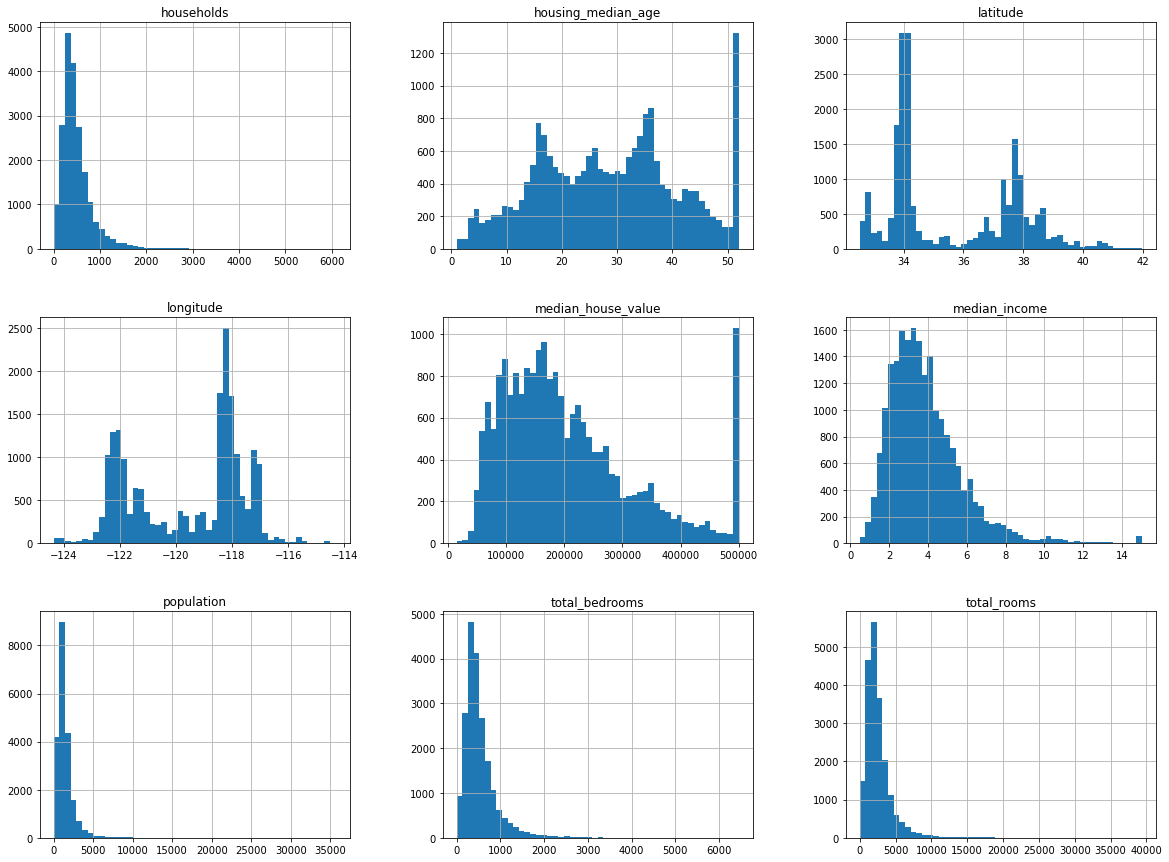

In [58]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [59]:
import numpy as np

def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [60]:
train_set, test_set = split_train_test(housing, 0.2)
print("train: ", len(train_set),"  ", "test: ", len(test_set))

train:  16512    test:  4128


In [61]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]



In [62]:
housing_with_id = housing.reset_index()
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

In [63]:
housing_with_id['id'] = housing["longitude"]*1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'id')

In [64]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [65]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0., 1.5, 3.0, 4.5, 6., np.inf], labels=[1, 2, 3, 4, 5])

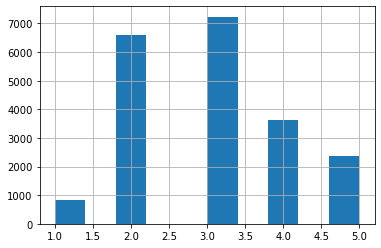

In [66]:
housing['income_cat'].hist()

In [67]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size= 0.2, random_state=42)

for train_index, test_index in split.split(housing, housing['income_cat']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [68]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [69]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop('income_cat', axis=1, inplace=True)

In [70]:
housing = strat_train_set.copy()

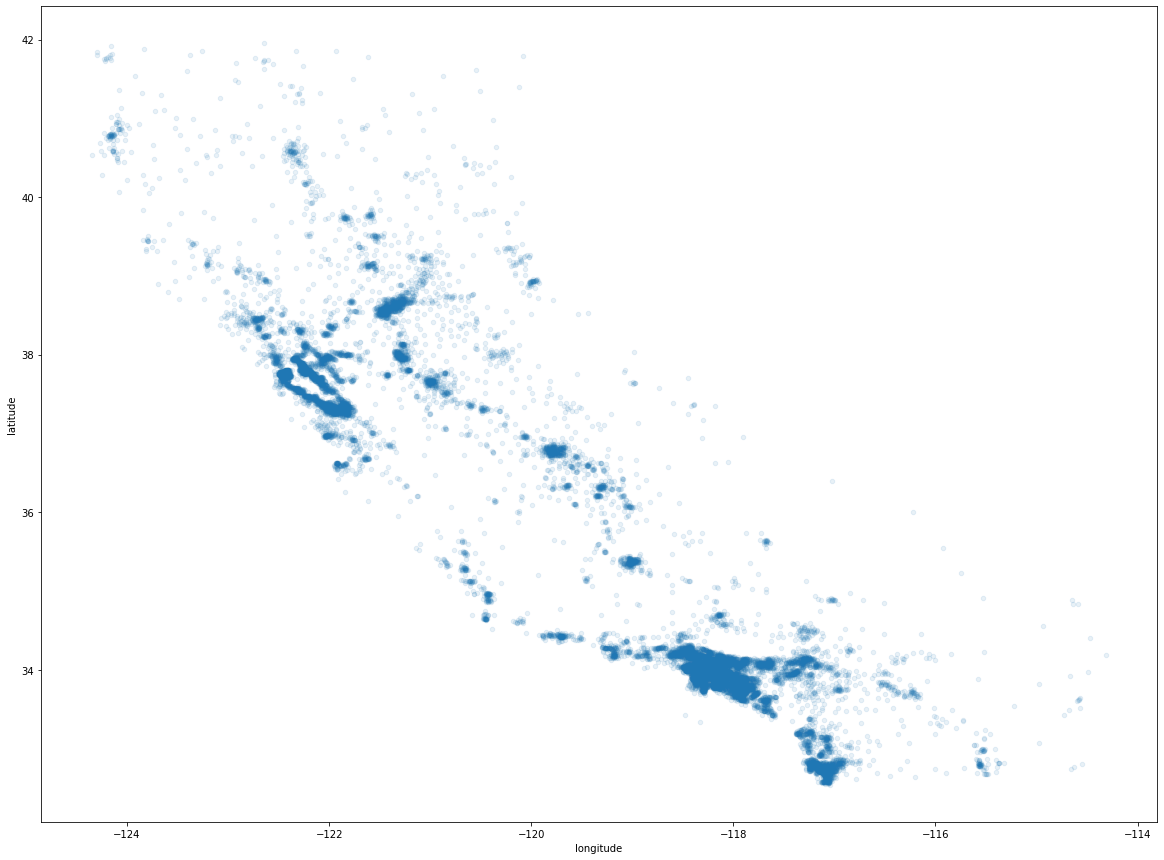

In [71]:
housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(20, 15), alpha=0.1)

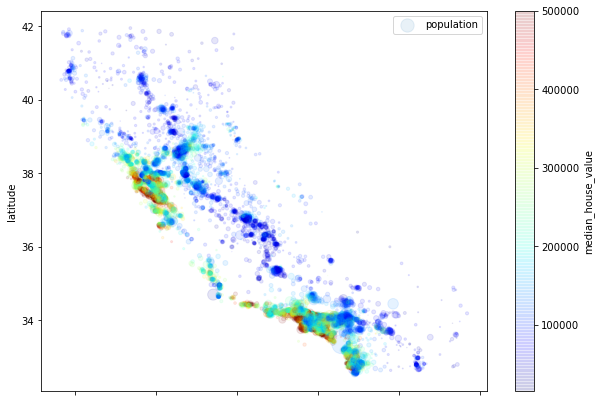

In [72]:
housing.plot(kind='scatter',
             x='longitude', y='latitude', figsize=(10, 7), alpha=0.1,
            s=housing["population"]/100, label="population", c="median_house_value",
             cmap=plt.get_cmap('jet'), colorbar=True)
plt.legend();

In [73]:
corr_matrix = housing.corr()

In [74]:
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

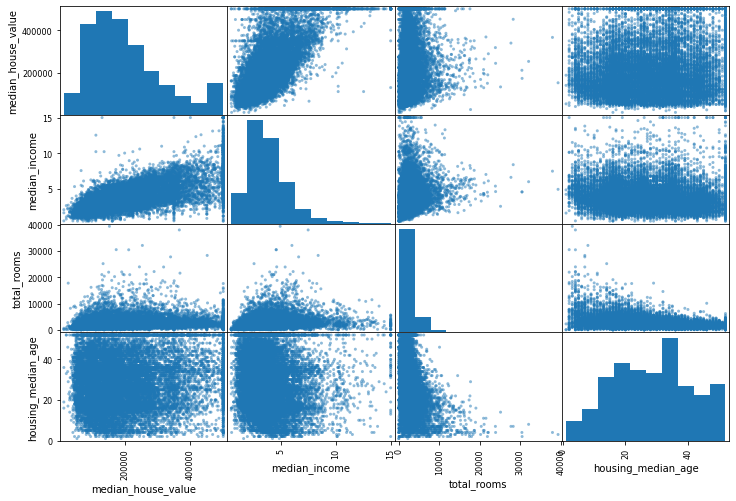

In [75]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,8));

In [76]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

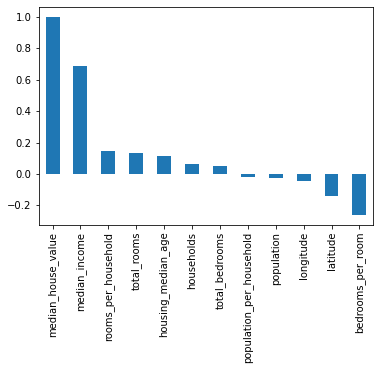

In [77]:
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False).plot(kind='bar')

In [78]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

In [79]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')

In [80]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [81]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [82]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [83]:
housing_num.median().values

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [84]:
X = imputer.transform(housing_num)

In [85]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [87]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [89]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [92]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [93]:
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()

In [94]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [95]:
housing_cat_1hot.toarray()

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]])

In [98]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] /X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]
        
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)


        

In [102]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [103]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ['ocean_proximity']

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)



In [104]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [105]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [106]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [107]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [108]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [109]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [110]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                        scoring='neg_mean_squared_error', cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [111]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Stand Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [68524.39216589 66816.05435203 70332.86362312 69154.70477947
 70134.48504505 75444.22576725 71958.32731981 70291.80129502
 76973.98261935 69405.39214321]
Mean: 70903.62291102023
Stand Deviation: 2958.762804201773


In [112]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring='neg_mean_squared_error', cv=10)

lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345083
Stand Deviation: 2731.674001798347


In [114]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring='neg_mean_squared_error', cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display(forest_rmse_scores)

array([49304.78753478, 47671.27585854, 49583.25282556, 52400.25099987,
       49857.00564542, 53357.25149182, 48732.03844786, 48110.3863109 ,
       52653.70455098, 50013.23111832])

In [115]:
display_scores(forest_rmse_scores)

Scores: [49304.78753478 47671.27585854 49583.25282556 52400.25099987
 49857.00564542 53357.25149182 48732.03844786 48110.3863109
 52653.70455098 50013.23111832]
Mean: 50168.318478406865
Stand Deviation: 1872.7018644135012


In [119]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error',
                          return_train_score=True)

In [120]:
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [121]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [122]:
grid_search.best_estimator_

RandomForestRegressor(max_features=6, n_estimators=30)

In [123]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

63526.29220358587 {'max_features': 2, 'n_estimators': 3}
55395.45253039884 {'max_features': 2, 'n_estimators': 10}
53080.61329908598 {'max_features': 2, 'n_estimators': 30}
60984.115729775214 {'max_features': 4, 'n_estimators': 3}
52640.954382746895 {'max_features': 4, 'n_estimators': 10}
50644.85115278886 {'max_features': 4, 'n_estimators': 30}
59577.17239057038 {'max_features': 6, 'n_estimators': 3}
52356.697314103985 {'max_features': 6, 'n_estimators': 10}
50054.578370629075 {'max_features': 6, 'n_estimators': 30}
59479.21962411053 {'max_features': 8, 'n_estimators': 3}
52057.283634777894 {'max_features': 8, 'n_estimators': 10}
50099.01684354175 {'max_features': 8, 'n_estimators': 30}
62939.821173430755 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54449.84676347929 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
60543.02725488305 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52798.41302298198 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [125]:
feature_importance = grid_search.best_estimator_.feature_importances_
feature_importance

array([8.02423312e-02, 7.69005267e-02, 4.17037405e-02, 1.65089158e-02,
       1.57063138e-02, 1.78187963e-02, 1.57398338e-02, 2.97655317e-01,
       5.29172393e-02, 1.04368495e-01, 1.07045140e-01, 1.83980122e-02,
       1.42837774e-01, 9.71435675e-05, 5.54643044e-03, 6.51399065e-03])

In [127]:
extra_attribs = ['rooms_per_hhold', 'pop_per_hhold', 'bedrooms_per_room']
cat_encoder = full_pipeline.named_transformers_['cat']
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importance, attributes), reverse=True)

[(0.29765531671130313, 'median_income'),
 (0.14283777411659326, 'INLAND'),
 (0.10704513999374048, 'bedrooms_per_room'),
 (0.10436849482351972, 'pop_per_hhold'),
 (0.0802423311656893, 'longitude'),
 (0.07690052669821702, 'latitude'),
 (0.05291723933964846, 'rooms_per_hhold'),
 (0.04170374053569446, 'housing_median_age'),
 (0.018398012247293104, '<1H OCEAN'),
 (0.017818796280130132, 'population'),
 (0.016508915826052437, 'total_rooms'),
 (0.015739833847598767, 'households'),
 (0.01570631375480512, 'total_bedrooms'),
 (0.006513990654037336, 'NEAR OCEAN'),
 (0.005546430438144836, 'NEAR BAY'),
 (9.714356753256175e-05, 'ISLAND')]

In [129]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop('median_house_value', axis=1)
y_test = strat_test_set['median_house_value'].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

In [130]:
final_rmse

47742.6123357418

In [131]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions-y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                        loc=squared_errors.mean(),
                        scale = stats.sem(squared_errors)))

array([45754.05948328, 49651.58714565])